In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import neuron as nrn
nrn.h.load_file('stdrun.hoc')
nrn.h.cvode_active(1.0)

from dlutils.spine import Spine
from dlutils.synapse import AMPANMDAExp2Synapse
from dlutils.numerics import double_exp

check_passive_props = False
check_AR = True
single_segment = True

> /Users/daniele/local/lib/python3.7/site-packages/neuron/__init__.py(105)<module>()
-> import sys
(Pdb) c


#### Functions used to describe the removal of the Mg block from the NMDA synapse

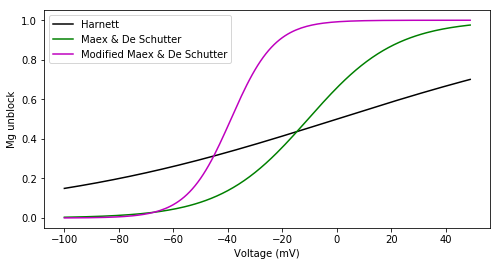

In [2]:
extMgConc = 1
alpha_vspom = -0.062
v0_block = 10
eta = 0.2801
mg_maex_orig = lambda v: 1. / (1. + eta * extMgConc * np.exp(alpha_vspom * (v - v0_block)))

extMgConc2 = extMgConc
alpha_vspom2 = alpha_vspom * 2
v0_block2 = v0_block - 20
eta2 = eta * 0.1
mg_maex_mod = lambda v: 1. / (1. + eta2 * extMgConc2 * np.exp(alpha_vspom2 * (v - v0_block2)))

v = np.arange(-100, 50)
mg_harnett = lambda v: 1. / (1. + np.exp(-0.062 * v * extMgConc / 3.57))

plt.figure(figsize=(8,4))
plt.plot(v, mg_harnett(v), 'k', label='Harnett')
plt.plot(v, mg_maex_orig(v), 'g', label='Maex & De Schutter')
plt.plot(v, mg_maex_mod(v), 'm', label='Modified Maex & De Schutter')
plt.xlabel('Voltage (mV)')
plt.ylabel('Mg unblock')
plt.legend(loc='best')

### Create a piece of dendrite

In [3]:
# a stretch of dendrite
length   = 1000   # [um]
diameter = 2     # [um]
# the area of the whole dendrite
area = np.pi * diameter * length
area_in_cm2 = area * 1e-8
print('Dendrite area: {:.1f} um2'.format(area))

dend = nrn.h.Section(name='dendrite')
# geometry
for y in np.arange(0., length+0.5, 1.):
    nrn.h.pt3dadd(0., y, 0., diameter, sec=dend)
dend.nseg = 1
if not single_segment:
    dend.nseg += int(np.ceil(length / 10)) * 2
# intrinsic properties
dend.Ra   = 150.   # [Ohm cm]
dend.cm   = 1.     # [uF cm^-2] !!! accounts for the presence of spines !!!

# passive mechanism
dend.insert('pas')
dend.e_pas = -65.     # [mV]
dend.g_pas = 1./2500  # [S cm^-2]

Rdend = 1e2 / (dend.g_pas * area)  # [MOhm]
C = dend.cm * area_in_cm2          # [uF]
tau = Rdend * C * 1e3              # [ms]
print(' Dendrite Rin: {:.1f} MOhm.'.format(Rdend))
print('Time constant: {:.1f} ms.'.format(tau))

Dendrite area: 6283.2 um2
 Dendrite Rin: 39.8 MOhm.
Time constant: 2.5 ms.


### Instantiate the spines

In [4]:
head_L    = 0.5         # [um]
head_diam = 0.5      # [um]
neck_L    = 1.58        # [um]
neck_diam = 0.077    # [um]
# neck_diam = 0.05     # [um]
spine_distance = 5   # [um] distance between neighboring spines
n_spines  = 9
L = spine_distance * (n_spines - 1)
norm_L = L / dend.L
spines = [Spine(dend, x, head_L, head_diam, neck_L, neck_diam, dend.Ra, i) \
          for i,x in enumerate(np.linspace(0.5 - norm_L/2, 0.5 + norm_L/2, n_spines))]
for spine in spines:
    spine.instantiate()

Spine axial resistivity: 150.00 Ohm cm.
Spine axial resistivity: 150.00 Ohm cm.
Spine axial resistivity: 150.00 Ohm cm.
Spine axial resistivity: 150.00 Ohm cm.
Spine axial resistivity: 150.00 Ohm cm.
Spine axial resistivity: 150.00 Ohm cm.
Spine axial resistivity: 150.00 Ohm cm.
Spine axial resistivity: 150.00 Ohm cm.
Spine axial resistivity: 150.00 Ohm cm.


### Insert a synapse into each spine

In [5]:
E = 0        # [mV]
weights = np.array([0.001, 1 * 0.002])  # AMPA and NMDA weights
AMPA_taus = {'tau1': 0.1, 'tau2':  1.0}
NMDA_taus = {'tau1': 1.0, 'tau2': 75.0}

print('AMPA:')
print('    tau_rise = {:.3f} ms'.format(AMPA_taus['tau1']))
print('   tau_decay = {:.3f} ms'.format(AMPA_taus['tau2']))
print('NMDA:')
print('    tau_rise = {:.3f} ms'.format(NMDA_taus['tau1']))
print('   tau_decay = {:.3f} ms'.format(NMDA_taus['tau2']))

synapses = [AMPANMDAExp2Synapse(spine.head, 1, E, weights, AMPA = AMPA_taus, \
                                NMDA = NMDA_taus) for spine in spines]

for syn in synapses:
    syn.nmda_syn.alpha_vspom *= 2
    syn.nmda_syn.v0_block -= 20
    syn.nmda_syn.eta *= 0.1
print('       alpha = {:.3f} 1/mV'.format(synapses[0].nmda_syn.alpha_vspom))
print('    v0_block = {:.3f} mV'.format(synapses[0].nmda_syn.v0_block))
print('         eta = {:.3f}'.format(synapses[0].nmda_syn.eta))

AMPA:
    tau_rise = 0.100 ms
   tau_decay = 1.000 ms
NMDA:
    tau_rise = 1.000 ms
   tau_decay = 75.000 ms
       alpha = -0.124 1/mV
    v0_block = -10.000 mV
         eta = 0.028


#### Sanity check for passive properties

In [6]:
if check_passive_props:
    stim = nrn.h.IClamp(dend(0.5))
    stim.delay = 500
    stim.dur = tau * 20
    stim.amp = -0.1

    rec = {}
    for lbl in 't','Vdend':
        rec[lbl] = nrn.h.Vector()
    rec['t'].record(nrn.h._ref_t)
    rec['Vdend'].record(dend(0.5)._ref_v)
    
    nrn.h.tstop = stim.delay + stim.dur + 200
    nrn.h.run()

    t = np.array(rec['t'])
    Vdend = np.array(rec['Vdend'])
    idx, = np.where((t > stim.delay - 10) & (t < stim.delay + stim.dur + 50))
    print('Measured input resistance: {:.1f} Mohm.'.format((np.min(Vdend) - Vdend[-1]) / stim.amp))
    x = np.linspace(0, 10*tau, 100)
    y = Rdend * np.abs(stim.amp) * np.exp(-x/tau) + np.min(Vdend)
    x += stim.delay
    plt.plot(t[idx], Vdend[idx], 'k', label='Dendrite')
    plt.plot(x, y, 'r', label='Exp. fit')
    plt.xlabel('Time (ms)')
    plt.ylabel('Voltage (mV)')
    plt.legend(loc='best')
    
    stim.amp = 0

#### Compute the amplitude ratio between spine and dendrite EPSPs

Spine EPSP amplitude when injecting in the dendrite: 19.74 mV.
Spine EPSP amplitude when injecting in the spine: 19.94 mV.
Spine to dendrite AR: 17.03 (dendrite to spine: 1.00).
            Neck Rin: 637.9 MOhm.


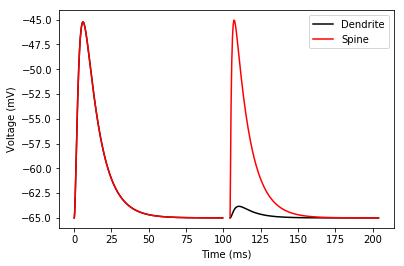

In [7]:
if check_AR:
    middle_spine = spines[int(n_spines/2)]
    
    t_onset = {'dend': 300., 'spine': 800.}
    if neck_diam == 0.05:
        amplitudes = {'dend': 0.155, 'spine': 0.0155}
    elif neck_diam == 0.077:
        amplitudes = {'dend': 0.63, 'spine': 0.0375}
    
    tr = 1.
    td = 10.
    t_end = 3000.
    dt = 0.5
    time = np.arange(0, t_end, dt)
    EPSP = {k: amplitudes[k] * double_exp(tr, td, t_onset[k], time) for k in t_onset}
    for k in EPSP:
        EPSP[k][np.isnan(EPSP[k])] = 0

    vec = {}
    vec['time'] = nrn.h.Vector(time)
    for k in EPSP:
        vec[k] = nrn.h.Vector(EPSP[k])

    stimuli = {'dend': nrn.h.IClamp(dend(0.5)), 'spine': nrn.h.IClamp(middle_spine.head(1))}
    for stim in stimuli.values():
        stim.dur = 1e6
    
    for k in stimuli:
        vec[k].play(stimuli[k]._ref_amp, vec['time'], 1)
    
    rec = {}
    for lbl in 't','Vdend','Vhead':
        rec[lbl] = nrn.h.Vector()
    rec['t'].record(nrn.h._ref_t)
    rec['Vdend'].record(dend(0.5)._ref_v)
    rec['Vhead'].record(middle_spine.head(1)._ref_v)
    
    nrn.h.v_init = dend.e_pas
    nrn.h.tstop = np.max(list(t_onset.values())) + 500
    nrn.h.run()
    
    t = np.array(rec['t'])
    Vdend = np.array(rec['Vdend'])
    Vspine = np.array(rec['Vhead'])
    
    idx, = np.where((t >= t_onset['dend']) & (t < t_onset['dend'] + 100))
    dend_to_spine = {'dend': np.max(Vdend[idx]) - dend.e_pas, 'spine': np.max(Vspine[idx]) - dend.e_pas}
    
    jdx, = np.where((t > t_onset['spine']) & (t < t_onset['spine'] + 100))
    spine_to_dend = {'dend': np.max(Vdend[jdx]) - dend.e_pas, 'spine': np.max(Vspine[jdx]) - dend.e_pas}
    AR = spine_to_dend['spine'] / spine_to_dend['dend']
    print('Spine EPSP amplitude when injecting in the dendrite: {:.2f} mV.'.format(dend_to_spine['spine']))
    print('Spine EPSP amplitude when injecting in the spine: {:.2f} mV.'.format(spine_to_dend['spine']))
    print('Spine to dendrite AR: {:.2f} (dendrite to spine: {:.2f}).'.\
          format(AR, dend_to_spine['spine'] / dend_to_spine['dend']))
    Rneck = (AR - 1) * Rdend
    print('Neck Rin: {:.1f} MOhm.'.format(Rneck))

    plt.plot(t[idx] - t_onset['dend'], Vdend[idx], 'k', label='Dendrite')
    plt.plot(t[idx] - t_onset['dend'], Vspine[idx], 'r', label='Spine')
    dt = t[idx[-1]] - t[idx[0]] + 5
    plt.plot(t[jdx] - t_onset['spine'] + dt, Vdend[jdx], 'k')
    plt.plot(t[jdx] - t_onset['spine'] + dt, Vspine[jdx], 'r')
    plt.legend(loc='best')
    plt.xlabel('Time (ms)')
    plt.ylabel('Voltage (mV)')

    for stim in stimuli.values():
        stim.dur = 0

### Set the presynaptic spike times

In [8]:
t0 = 1000.
dt = 1000.
spike_times = [np.sort(t0 + (n_spines - 1) * dt - np.arange(i) * dt) for i in range(n_spines, 0, -1)]
for i in range(n_spines):
    for j in range(n_spines-i):
        spike_times[i][j] += i * 0.3
for syn, spks in zip(synapses, spike_times):
    syn.set_presynaptic_spike_times(spks)

In [9]:
spike_times

[array([1000., 2000., 3000., 4000., 5000., 6000., 7000., 8000., 9000.]),
 array([2000.3, 3000.3, 4000.3, 5000.3, 6000.3, 7000.3, 8000.3, 9000.3]),
 array([3000.6, 4000.6, 5000.6, 6000.6, 7000.6, 8000.6, 9000.6]),
 array([4000.9, 5000.9, 6000.9, 7000.9, 8000.9, 9000.9]),
 array([5001.2, 6001.2, 7001.2, 8001.2, 9001.2]),
 array([6001.5, 7001.5, 8001.5, 9001.5]),
 array([7001.8, 8001.8, 9001.8]),
 array([8002.1, 9002.1]),
 array([9002.4])]

#### Make the recorders

In [10]:
rec = {}
for lbl in 't','Vdend':
    rec[lbl] = nrn.h.Vector()
rec['t'].record(nrn.h._ref_t)
rec['Vdend'].record(dend(0.5)._ref_v)
for i,spine in enumerate(spines):
    rec['Vspine-{}'.format(i)] = nrn.h.Vector()
    rec['IAMPA-{}'.format(i)] = nrn.h.Vector()
    rec['gAMPA-{}'.format(i)] = nrn.h.Vector()
    rec['INMDA-{}'.format(i)] = nrn.h.Vector()
    rec['gNMDA-{}'.format(i)] = nrn.h.Vector()
    rec['MgBlock-{}'.format(i)] = nrn.h.Vector()
    rec['Vspine-{}'.format(i)].record(spine.head(0.5)._ref_v)
    rec['IAMPA-{}'.format(i)].record(synapses[i].syn[0]._ref_i)
    rec['gAMPA-{}'.format(i)].record(synapses[i].syn[0]._ref_g)
    rec['INMDA-{}'.format(i)].record(synapses[i].syn[1]._ref_i)
    rec['gNMDA-{}'.format(i)].record(synapses[i].syn[1]._ref_g)
    rec['MgBlock-{}'.format(i)].record(synapses[i].syn[1]._ref_mgBlock)

#### Run the simulation

In [11]:
nrn.h.cvode_active(1)
nrn.h.tstop = t0 + n_spines * dt
nrn.h.v_init = dend.e_pas
nrn.h.run()

0.0

#### Get the data from the recorders

In [12]:
t = np.array(rec['t'])
Vdend = np.array(rec['Vdend'])
iampa = np.array([np.array(rec['IAMPA-{}'.format(i)])*1e3 for i in range(n_spines)])
inmda = np.array([np.array(rec['INMDA-{}'.format(i)])*1e3 for i in range(n_spines)])
gampa = np.array([np.array(rec['gAMPA-{}'.format(i)])*1e3 for i in range(n_spines)])
gnmda = np.array([np.array(rec['gNMDA-{}'.format(i)])*1e3 for i in range(n_spines)])
MgBlock = np.array([np.array(rec['MgBlock-{}'.format(i)])for i in range(n_spines)])
Vspine = np.array([np.array(rec['Vspine-{}'.format(i)]) for i in range(n_spines)])

#### Measure the amplitude ratio when the input is synaptic

AR = 28.709


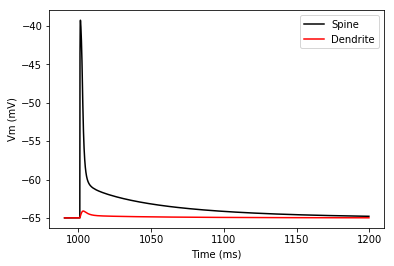

In [13]:
idx, = np.where((t > 990) & (t < 1200))
EPSP_spine = np.max(Vspine[0,idx]) - Vspine[0,-1]
EPSP_dend = np.max(Vdend[idx]) - Vdend[-1]
AR = EPSP_spine / EPSP_dend
print('AR = {:.3f}'.format(AR))
plt.plot(t[idx], Vspine[0,idx], 'k', label='Spine')
plt.plot(t[idx], Vdend[idx], 'r', label='Dendrite')
plt.xlabel('Time (ms)')
plt.ylabel('Vm (mV)')
plt.legend(loc='best');

#### Measure the dendritic EPSPs and the NMDA conductance values

In [14]:
V_pks = np.zeros(n_spines)
dG = np.zeros(n_spines)
for i,spk in enumerate(spike_times[0]):
    idx = (t > spk) & (t < spk + 200)
    V_pks[i] = np.max(Vdend[idx])
    dG[i] = np.max(gnmda[0,idx] * MgBlock[0,idx])
dV = V_pks - Vdend[-1]

#### Plot the time course of the dendritic EPSPs and the NMDA conductance for increasing number of synaptic inputs

Text(0, 0.5, 'NMDA conductance (nS)')

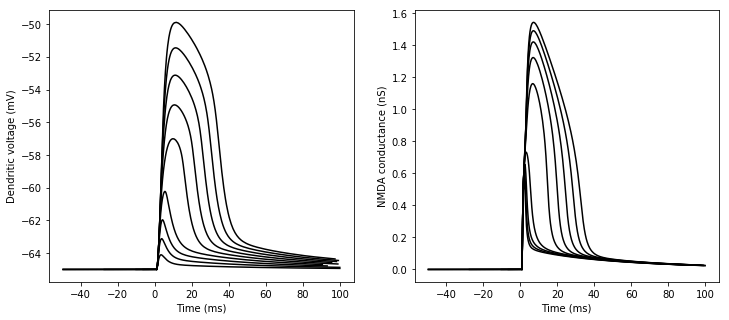

In [15]:
window = [50, 100]
fig,(ax1,ax2) = plt.subplots(1, 2, figsize=(12,5), sharex=True)
for spk in spike_times[0]:
    idx = (t > spk - window[0]) & (t < spk + window[1])
    ax1.plot(t[idx] - spk, Vdend[idx], 'k')
    ax2.plot(t[idx] - spk, gnmda[0,idx] * MgBlock[0,idx], 'k')
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Dendritic voltage (mV)')
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('NMDA conductance (nS)');

#### Plot the amplitude of the dendritic EPSPs and of the NMDA conductance as a function of the number of synaptic inputs

(0.4710569822670926, 1.643845294126571)

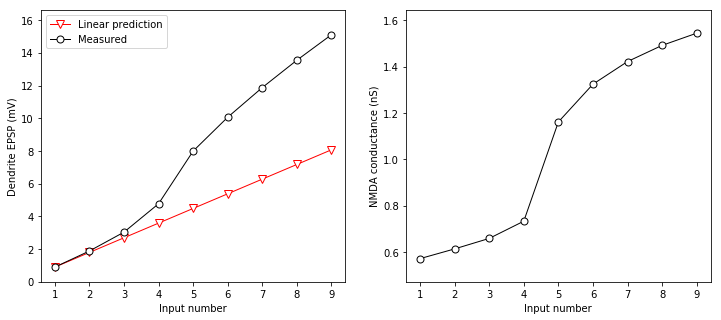

In [16]:
n = 1 + np.arange(n_spines)
fig,(ax1,ax2) = plt.subplots(1, 2, figsize=(12,5), sharex=True)
ax1.plot(n, n * dV[0], 'rv-', lw=1, markerfacecolor='w', markersize=8, label='Linear prediction')
ax1.plot(n, dV, 'ko-', lw=1, markerfacecolor='w', markersize=7, label='Measured')
ax2.plot(n, dG, 'ko-', lw=1, markerfacecolor='w', markersize=7, label='Measured')
ax1.set_xlabel('Input number')
ax1.set_ylabel('Dendrite EPSP (mV)')
ax2.set_xlabel('Input number')
ax2.set_ylabel('NMDA conductance (nS)')
ax1.legend(loc='best')
ax1.set_ylim([0, np.max([dV[-1], dV[0]*n_spines]) * 1.1])
ax2.set_ylim([dG[0] - 0.1, dG[-1] + 0.1]);